# Deep Convolutional GANs

Brief introduction to Deep Convolutional Generative Adversarial Networks or DCGANs. This notebook is organized as follows:

1. **Research Paper**
* **Background**
* **Definition**
* **Training DCGANs with MNIST dataset, Keras and TensorFlow**

## 1. Research Paper

* [Unsupervised Representation Learning With Deep Convolutional](https://arxiv.org/pdf/1511.06434.pdf)

## 2. Background

Brief definition of some concepts, such as convolution, Convolutional Neural Network (CNN) and GANs.

### Convolution

Convolution is a mathematical operation which describes a rule of how to mix two functions or pieces of information.

* Features Map $I$
* Convolution kernel $K$
* Map of transformed features $S(i, j)$

![convolution](https://devblogs.nvidia.com/wp-content/uploads/2015/11/convolution.png)

### Convolutional Neural Network (CNN)

Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers.

These convolutional layers have parameters that are learned so that these filters are adjusted automatically to extract the most useful information for the task at hand.

* Input is a multidimensional array of data,
* Kernel is a multidimensional array of parameters,
* These multidimensional arrays are tensors.

#### Layers CNN

* Convolution: extract features from imagem.
* Pooling: reduce dimension of entry.
* Dense / Fully connected: connect the layers.

### GANs

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **cost function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

## 3. Definition

The difference between the simple GAN and the DCGAN, is the generator of the simple GAN is a simple fully connected network. The generator of the DCGAN uses the transposed convolution (Fractionally-strided convolution or 
Deconvolution) technique to perform up-sampling of 2D image size.

DCGAN are mainly composes of convolution layers without max pooling or fully connected layers. It uses convolutional stride and transposed convolution for the downsampling and the upsampling. 

### Network Design

<img src="../../img/network_design_dcgan.png" width="600"> 


### Cost Funcion


$$ \underset{G}{min} \: \underset{D}{max} \; V_{DCGAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

> * Replace all max pooling with convolutional stride.
    Use transposed convolution for upsampling.
    Eliminate fully connected layers.
    Use Batch normalization except the output layer for the generator and the input layer of the discriminator.
    Use ReLU in the generator except for the output which uses tanh.
    Use LeakyReLU in the discriminator.*

## 4. Training DCGANs with MNIST dataset,  Keras and TensorFlow

A DCGANs implementation using the transposed convolution technique and the [Keras](https://keras.io/) library.

* **Data**
    * Rescale the MNIST images to be between -1 and 1.
    
* **Generator**
    * Use the **inverse of convolution**, called transposed convolution.
    * **ReLU activation** and **BatchNormalization**.
    * The input to the generator is the **normal distribution** $z$ or latent sample (100 values).
    * The last activation is **tanh**.
    
* **Discriminator**
    * **Convolutional neural network**  and **LeakyReLU activation**.
    * The last activation is **sigmoid**.
    
* **Loss**
    * binary_crossentropy

* **Optimizer**
    * Adam(lr=0.0002, beta_1=0.5)

* batch_size = 64
* epochs = 100

### 1. Load data

#### Load libraries

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import random
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
!pip install extra_keras_datasets
from extra_keras_datasets import emnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model
from keras import backend as K

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/cgan"

Mounted at /content/drive
 02_DCGAN_MNIST.ipynb   data	     'ep 94.png'
 03_CGAN_MNIST.ipynb   'ep 0.png'    'ep cgan_emist_weight.h5'
 0.png		       'ep 141.png'   mnist-cgan.ipynb
 47.png		       'ep 188.png'  'text to image code 1.ipynb'
 94.png		       'ep 235.png'  'text to image code 2.ipynb'
 cgan_emist.h5	       'ep 282.png'   Train
 cgan_emist_weight.h5  'ep 47.png'    TrainFixed_results


#### Getting the data

In [4]:
# load dataset
(X_train, y_train), (X_test, y_test) = emnist.load_data(type='balanced')

743900280/743900280 [==============================] - 102s 0us/step


#### Explore visual data

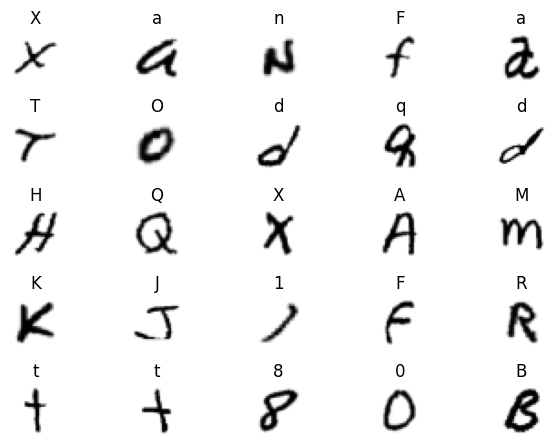

In [5]:
class_idx = ['0','1','2','3','4','5','6','7','8','9',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
             'a','b','d','e','f','g','h','n','q','r','t']
for i in range(25):
    # pick random image index from dataset to show
    index = random.randint(0, len(X_train))
    # define subplot
    plt.subplot(5, 5, 1 + i)
    plt.tight_layout()
    # turn off axis
    plt.axis('off')
    # change to grayscale as our images are in grayscale
    plt.imshow(X_train[index], cmap='gray_r')
    # show image title according to the real dataset classes
    plt.title(class_idx[y_train[index]])

#### Reshaping and normalizing the inputs

In [6]:
print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (112800, 28, 28)
X_train reshape: (112800, 28, 28, 1)


### 2. Define model

#### Generator

In [7]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 7x7x256
generator.add(Dense(7*7*128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((7, 7, 128)))

# Conv 1: 14x14x128
generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# Conv 2: 28x28x64
generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# # Conv 3: 28x28x32
# generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
# generator.add(BatchNormalization(momentum=0.8))
# generator.add(ReLU(0.2))

# Conv 4: 28x28x1
generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='tanh'))

#### Generator model visualization

In [8]:
# prints a summary representation of your model
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       73792     
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 64)       256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 32)       1

#### Discriminator

In [9]:
# Discriminator network
discriminator = Sequential()

# Conv 1: 14x14x64
discriminator.add(Conv2D(32, kernel_size=3, strides=2, padding='same',
                         input_shape=(28, 28, 1), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


#### Discriminator model visualization

In [10]:
# prints a summary representation of your model
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                      

### 3. Compile model

#### Compile discriminator

In [11]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


#### Combined network

We connect the generator and the discriminator to make a DCGAN.

In [12]:
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

#### GAN model vizualization

In [13]:
# prints a summary representation of your model
d_g.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         726401    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 95489     
                                                                 
Total params: 821,890
Trainable params: 726,209
Non-trainable params: 95,681
_________________________________________________________________


### 4. Fit model

epoch = 1/100, d_loss=0.164, g_loss=0.373                                                                                                     
1/1 [==============================] - 0s 193ms/step


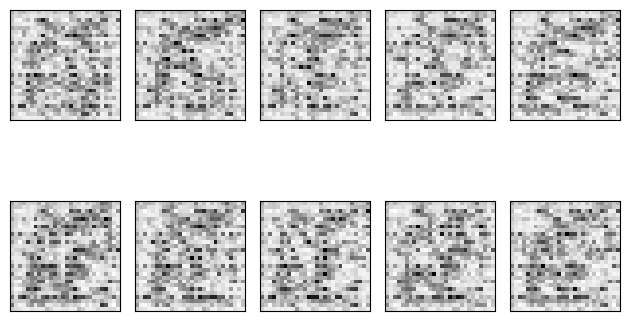

epoch = 2/100, d_loss=0.163, g_loss=0.257                                                                                                     
epoch = 3/100, d_loss=0.163, g_loss=0.223                                                                                                     
epoch = 4/100, d_loss=0.163, g_loss=0.280                                                                                                     
epoch = 5/100, d_loss=0.163, g_loss=0.326                                                                                                     
epoch = 6/100, d_loss=0.163, g_loss=0.402                                                                                                     
epoch = 7/100, d_loss=0.163, g_loss=0.284                                                                                                     
epoch = 8/100, d_loss=0.163, g_loss=0.317                                                                                                     

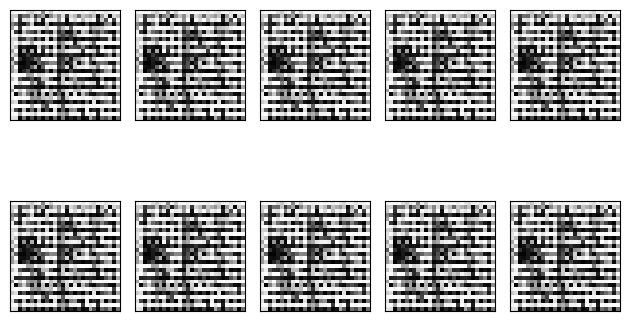

epoch = 12/100, d_loss=0.163, g_loss=0.158                                                                                                     
epoch = 13/100, d_loss=0.163, g_loss=0.285                                                                                                     
epoch = 14/100, d_loss=0.163, g_loss=0.241                                                                                                     
epoch = 15/100, d_loss=0.163, g_loss=0.239                                                                                                     
epoch = 16/100, d_loss=0.163, g_loss=0.177                                                                                                     
epoch = 17/100, d_loss=0.163, g_loss=0.495                                                                                                     
epoch = 18/100, d_loss=0.163, g_loss=0.817                                                                                              

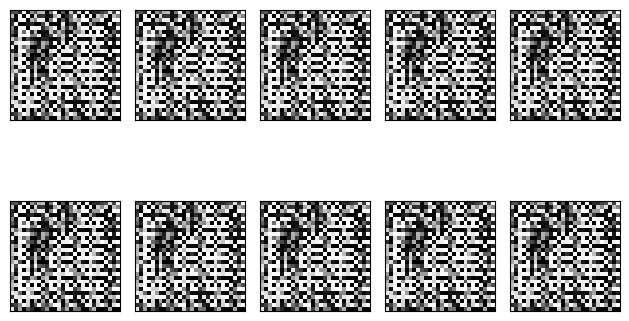

epoch = 22/100, d_loss=0.163, g_loss=0.333                                                                                                     
epoch = 23/100, d_loss=0.163, g_loss=0.346                                                                                                     
epoch = 24/100, d_loss=0.163, g_loss=0.257                                                                                                     
epoch = 25/100, d_loss=0.163, g_loss=0.259                                                                                                     
epoch = 26/100, d_loss=0.163, g_loss=0.342                                                                                                     
epoch = 27/100, d_loss=0.163, g_loss=0.485                                                                                                     
epoch = 28/100, d_loss=0.163, g_loss=0.408                                                                                              

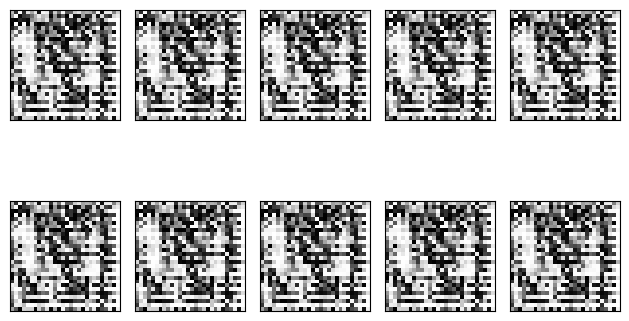

epoch = 32/100, d_loss=0.163, g_loss=0.271                                                                                                     
epoch = 33/100, d_loss=0.163, g_loss=0.316                                                                                                     
epoch = 34/100, d_loss=0.163, g_loss=0.509                                                                                                     
epoch = 35/100, d_loss=0.163, g_loss=0.834                                                                                                     
epoch = 36/100, d_loss=0.163, g_loss=0.884                                                                                                     
epoch = 37/100, d_loss=0.163, g_loss=0.728                                                                                                     
epoch = 38/100, d_loss=0.163, g_loss=0.591                                                                                              

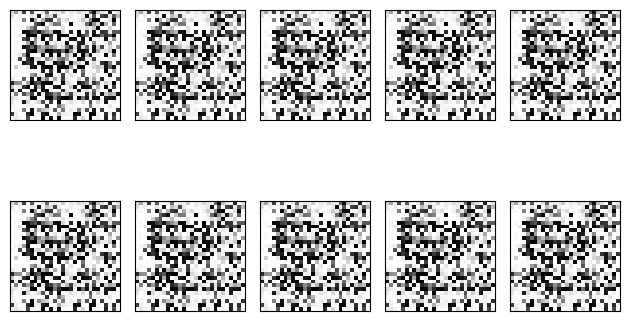

epoch = 42/100, d_loss=0.163, g_loss=0.513                                                                                                     
epoch = 43/100, d_loss=0.163, g_loss=0.668                                                                                                     
epoch = 44/100, d_loss=0.163, g_loss=0.639                                                                                                     
epoch = 45/100, d_loss=0.163, g_loss=0.725                                                                                                     
epoch = 46/100, d_loss=0.163, g_loss=0.978                                                                                                     
epoch = 47/100, d_loss=0.163, g_loss=1.202                                                                                                     
epoch = 48/100, d_loss=0.163, g_loss=1.114                                                                                              

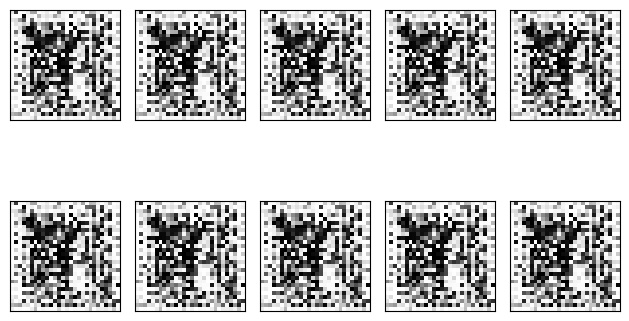

epoch = 52/100, d_loss=0.163, g_loss=0.641                                                                                                     
epoch = 53/100, d_loss=0.163, g_loss=0.901                                                                                                     
epoch = 54/100, d_loss=0.163, g_loss=0.683                                                                                                     
epoch = 55/100, d_loss=0.163, g_loss=0.656                                                                                                     
epoch = 56/100, d_loss=0.163, g_loss=0.692                                                                                                     
epoch = 57/100, d_loss=0.163, g_loss=0.562                                                                                                     
epoch = 58/100, d_loss=0.163, g_loss=0.322                                                                                              

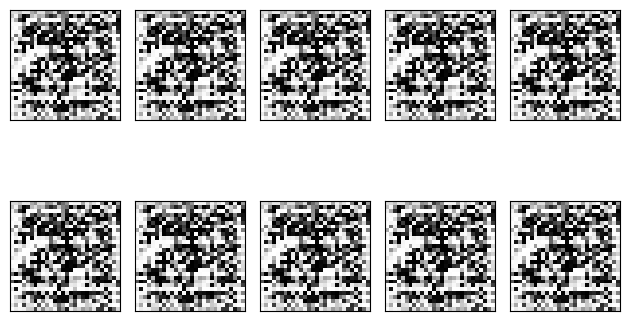

epoch = 62/100, d_loss=0.163, g_loss=0.324                                                                                                     
epoch = 63/100, d_loss=0.163, g_loss=0.510                                                                                                     
epoch = 64/100, d_loss=0.163, g_loss=0.807                                                                                                     
epoch = 65/100, d_loss=0.163, g_loss=0.655                                                                                                     
epoch = 66/100, d_loss=0.163, g_loss=0.621                                                                                                     
epoch = 67/100, d_loss=0.163, g_loss=0.425                                                                                                     
epoch = 68/100, d_loss=0.163, g_loss=0.486                                                                                              

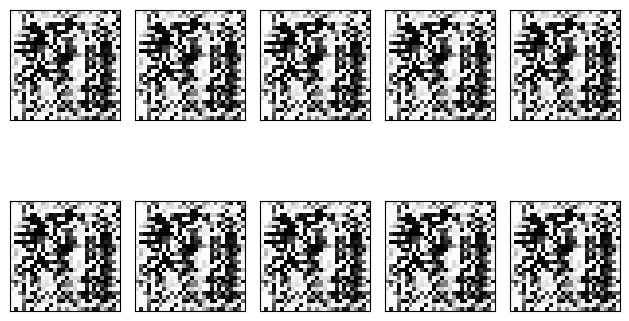

epoch = 72/100, d_loss=0.163, g_loss=0.441                                                                                                     
epoch = 73/100, d_loss=0.163, g_loss=0.404                                                                                                     
epoch = 74/100, d_loss=0.163, g_loss=0.452                                                                                                     
epoch = 75/100, d_loss=0.163, g_loss=0.469                                                                                                     
epoch = 76/100, d_loss=0.163, g_loss=0.433                                                                                                     
epoch = 77/100, d_loss=0.163, g_loss=0.436                                                                                                     
epoch = 78/100, d_loss=0.163, g_loss=0.479                                                                                              

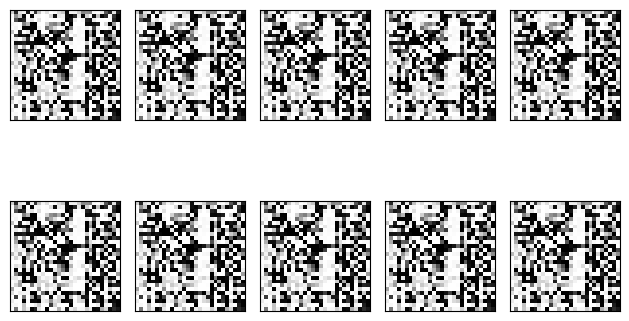

epoch = 82/100, d_loss=0.163, g_loss=0.608                                                                                                     
epoch = 83/100, d_loss=0.163, g_loss=0.464                                                                                                     
epoch = 84/100, d_loss=0.163, g_loss=0.424                                                                                                     
epoch = 85/100, d_loss=0.163, g_loss=0.460                                                                                                     
epoch = 86/100, d_loss=0.163, g_loss=0.520                                                                                                     
epoch = 87/100, d_loss=0.163, g_loss=0.488                                                                                                     
epoch = 88/100, d_loss=0.163, g_loss=0.468                                                                                              

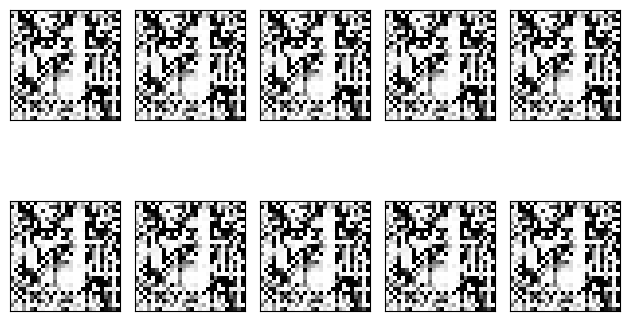

epoch = 92/100, d_loss=0.163, g_loss=0.442                                                                                                     
epoch = 93/100, d_loss=0.163, g_loss=0.429                                                                                                     
epoch = 94/100, d_loss=0.163, g_loss=0.419                                                                                                     
epoch = 95/100, d_loss=0.163, g_loss=0.411                                                                                                     
epoch = 96/100, d_loss=0.163, g_loss=0.454                                                                                                     
epoch = 97/100, d_loss=0.163, g_loss=0.333                                                                                                     
epoch = 98/100, d_loss=0.163, g_loss=0.273                                                                                              

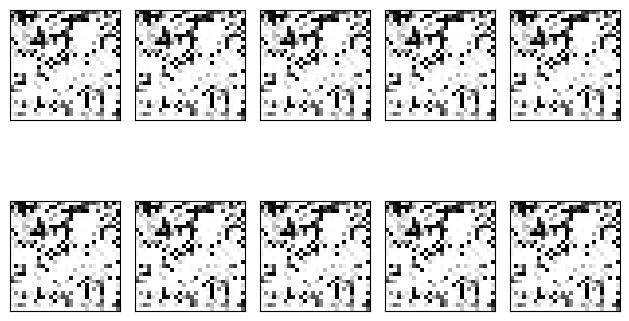

In [14]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch, y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        d_g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

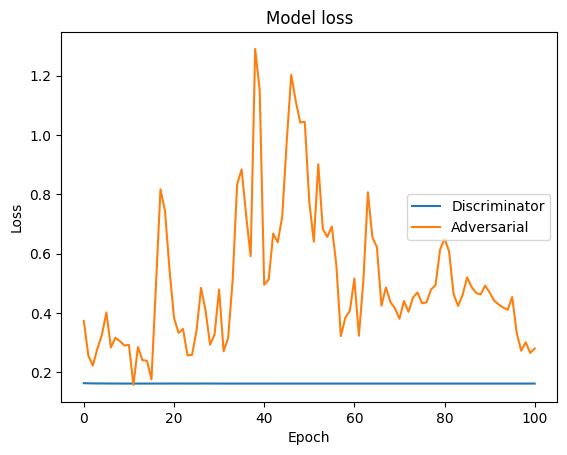

In [15]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

In [16]:
y_test.shape

(18800,)

## References

* [Convolution](https://devblogs.nvidia.com/deep-learning-nutshell-core-concepts/)
* [GAN — DCGAN (Deep convolutional generative adversarial networks)](https://medium.com/@jonathan_hui/gan-dcgan-deep-convolutional-generative-adversarial-networks-df855c438f)